In [41]:
from ay_torch import *
%matplotlib widget

# Testing data augmentation for CIFAR-10

In [42]:
def GetDataTransforms(mode):
  if mode=='train':
    # return torchvision.transforms.Compose([
    #     torchvision.transforms.Resize(256),
    #     torchvision.transforms.RandomAffine(degrees=(-10, 10), scale=(1.0, 1.1)),
    #     #torchvision.transforms.RandomRotation(degrees=10),
    #     torchvision.transforms.RandomHorizontalFlip(),
    #     torchvision.transforms.RandomResizedCrop(224),
    #     torchvision.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0),
    #     torchvision.transforms.ToTensor(),
    #     #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    #   ])
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(224),
        torchvision.transforms.Resize(460),
        torchvision.transforms.Pad(20, padding_mode='constant'),  #'reflect'
        # torchvision.transforms.RandomRotation(degrees=10),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(460),
        # Warp(magnitude=max_warp=0.2, p=p_affine=0.75, **tkw)
        # Zoom(min_zoom=min_zoom=1., max_zoom=max_zoom=1.1, p=p_affine=0.75, **tkw)
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.RandomAffine(degrees=(-10,10), scale=(0.75,1.1)),
        torchvision.transforms.RandomResizedCrop(224, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor()
      ])

In [43]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 6 frog
dset_train[0][0] value range: tensor(0.0039) tensor(0.8980)
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 3 cat


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
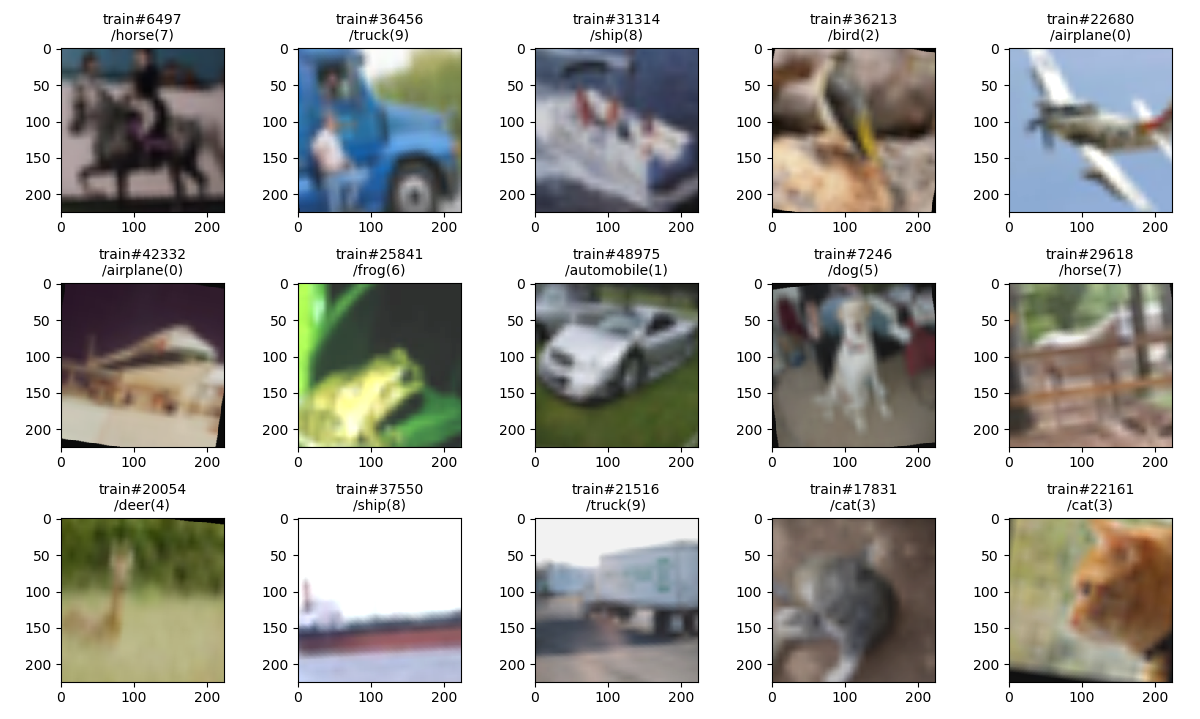

In [45]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

### TEST: Using fastai's data augmentation

The objective of this test is to know if the data augmentation of fastai contributes the learning CIFAR-10 task.

Conclusion: Yes, fastai's data augmentation increases the accuracy.

- With my data augmentation: 89.x % --> After updating, reached 92.7 % @14, but compt time/epoch is increase (169s)
- With fastai's data augmentation: 92.5 % (using pretrained parameters), 93.2 % @29 (no pretrained)

In [40]:
import fastai.vision.all
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label,
                                    item_tfms=fastai.vision.all.Resize(460),
                                    batch_tfms=fastai.vision.all.aug_transforms(size=224, min_scale=0.75) )
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label )
dls= dblock.dataloaders(path, bs=64)
dl_train,dl_test= dls.train, dls.valid
dset_train,dset_test= dls.train_ds, dls.valid_ds
dset_train.classes,dset_test.classes= dl_train.vocab,dl_test.vocab

## ResNet-18 with pretrained network parameters

In [46]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

#Load pretrained model parameters.
url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [47]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 224, 224)


Layer (type:depth-idx)                        Output Shape              Param #
TResNet                                       --                        --
├─Sequential: 1-1                             [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                            [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                       [1, 32, 112, 112]         64
│    └─ReLU: 2-3                              [1, 32, 112, 112]         --
├─Sequential: 1-2                             [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                            [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                       [1, 32, 112, 112]         64
│    └─ReLU: 2-6                              [1, 32, 112, 112]         --
├─Sequential: 1-3                             [1, 64, 112, 112]         --
│    └─Conv2d: 2-7                            [1, 64, 112, 112]         18,432
│    └─BatchNorm2d: 2-8                       [1, 64, 112, 112]         128
│    └─ReLU

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
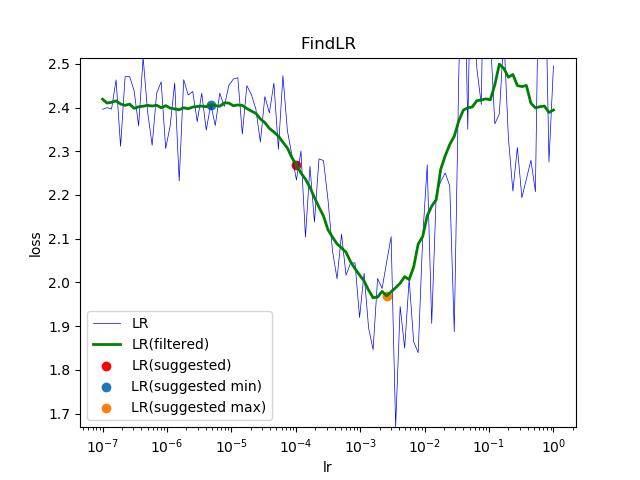

lr= 0.0001023292992280754, lr_min=4.7863009232263826e-06, lr_max=0.0025703957827688637


In [48]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	1.59081432	1.52038739	0.46666003	142.742871
1	0.93816767	1.21512612	0.62310908	142.226163
2	0.69751004	0.88656399	0.71248010	142.275564
3	0.53542788	0.59311846	0.80294586	142.265888
4	0.43439578	0.46669283	0.84454618	142.541379
5	0.34819584	0.37875378	0.87191481	142.784238
6	0.27025635	0.33642501	0.89052548	142.382912
7	0.20139782	0.27865285	0.90724522	142.900174
8	0.15137129	0.25716394	0.91371417	150.019307
9	0.12548709	0.25152947	0.91759554	150.083588


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
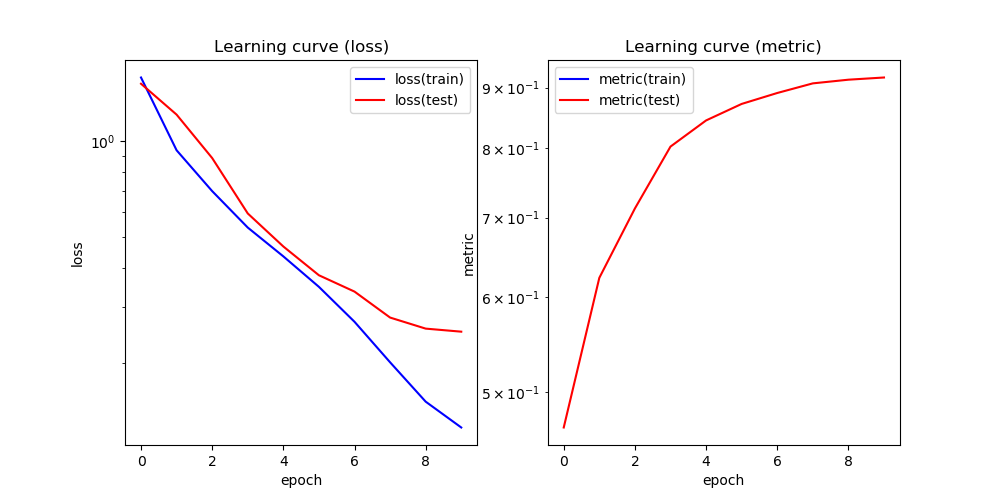

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
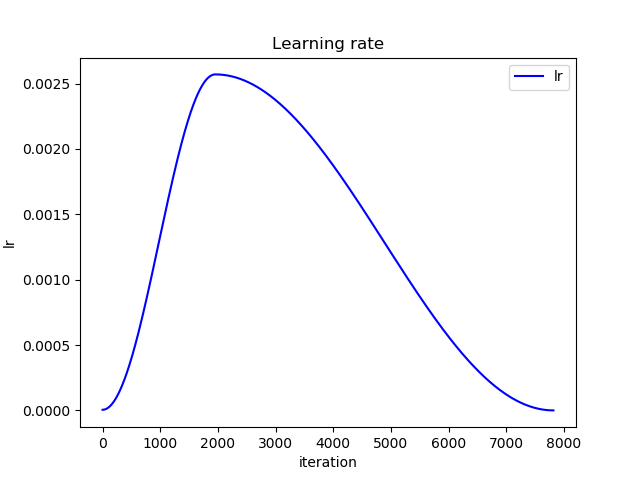

In [49]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
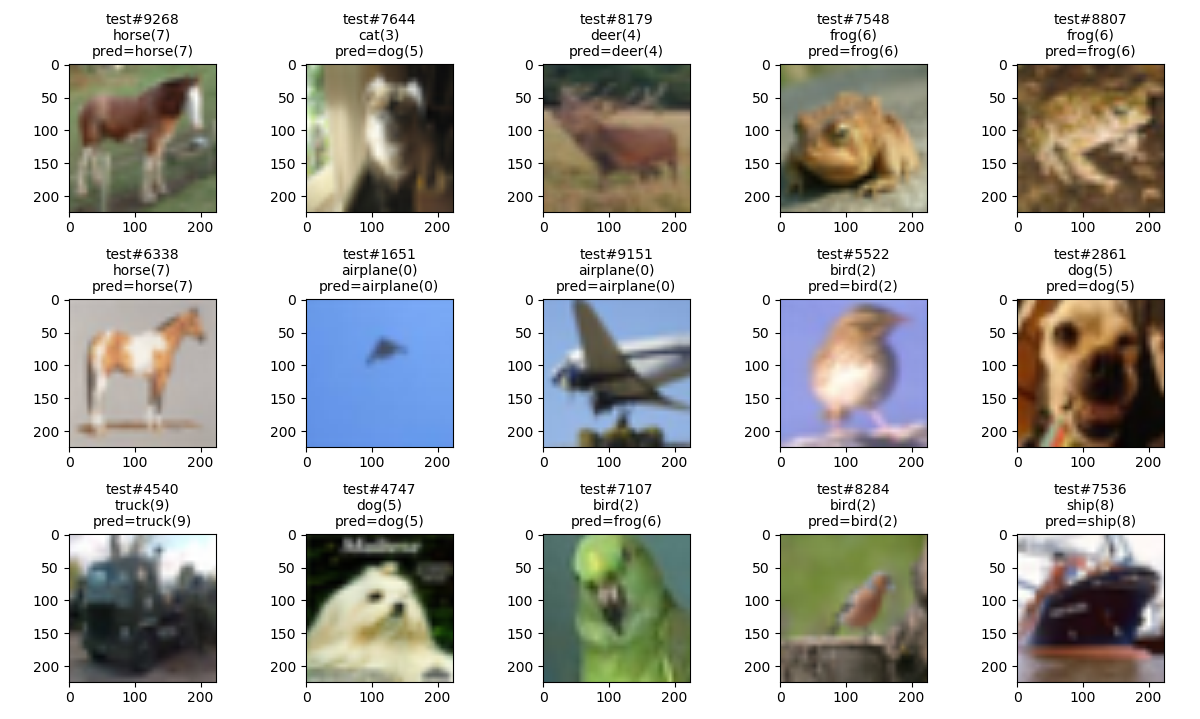

In [50]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## ResNet-18 without pretrained network parameters

In [19]:
#Setup a neural network.
net= TResNet18(in_channels=3, out_channels=len(dset_train.classes))

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [ ]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

FindLR progress: 0.0%


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


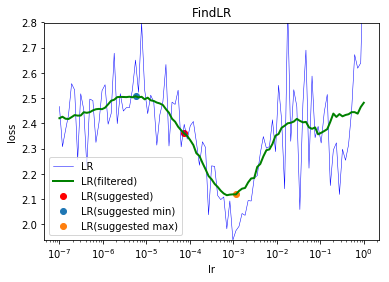

lr= 7.413102413009172e-05, lr_min=5.62341325190349e-06, lr_max=0.001148153621496882


In [21]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	0.11678427	0.28719760	0.90691489	102.346642
21	0.21925186	0.40454508	0.87283910	103.073038
22	0.25967861	0.36876889	0.88164894	103.301678
23	0.22702160	0.38691143	0.87483378	103.237663
24	0.19352214	0.31272323	0.89752327	103.070234
25	0.15430178	0.27878397	0.90774601	103.147643
26	0.11371717	0.25413959	0.91971410	103.264879
27	0.08048933	0.22971035	0.92910572	103.339758
28	0.06094797	0.22166467	0.93101729	102.730049
29	0.05141830	0.21617413	0.93209774	103.183279


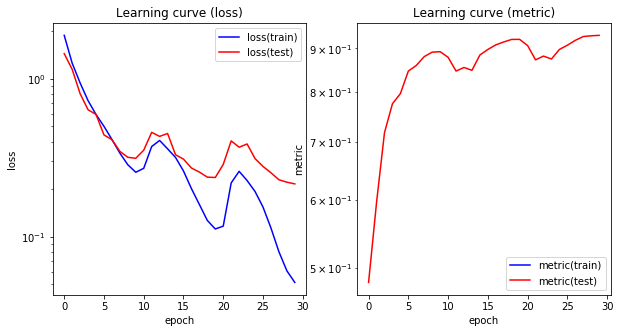

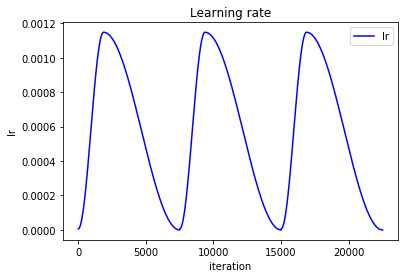

In [24]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## Tiny ResNet made with ResBlock

In [57]:
class TResNetTiny(torch.nn.Module):
  def __init__(self, n_classes):
    super(TResNetTiny,self).__init__()
    # n_layers= [3,16,32,64,128,256]
    # strides= [1,2,2,2,2,2]  #For 224x224 images
    n_layers= [3,16,32,64,128]
    strides= [1,2,2,2,2]  #For 224x224 images
    self.net= torch.nn.Sequential(
          *[TResBlock(1, c_in, c_out, kernel_size=3, stride=s) for c_in,c_out,s in zip(n_layers[:-1],n_layers[1:],strides)],
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(n_layers[-1], n_classes)
          )
  def forward(self, x):
    return self.net(x)

In [58]:
#Setup a neural network.
net= TResNetTiny(n_classes=len(dset_train.classes))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [59]:
# input_size= (1,)+dset_train[0][0].shape
input_size= (1,3,224,224)
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 224, 224)


Layer (type:depth-idx)                        Output Shape              Param #
TResNetTiny                                   --                        --
├─Sequential: 1-1                             [1, 10]                   --
│    └─TResBlock: 2-1                         [1, 16, 224, 224]         --
│    │    └─Sequential: 3-1                   [1, 16, 224, 224]         2,800
│    │    └─Sequential: 3-2                   [1, 16, 224, 224]         80
│    │    └─ReLU: 3-3                         [1, 16, 224, 224]         --
│    └─TResBlock: 2-2                         [1, 32, 112, 112]         --
│    │    └─Sequential: 3-4                   [1, 32, 112, 112]         13,952
│    │    └─Sequential: 3-5                   [1, 32, 112, 112]         576
│    │    └─ReLU: 3-6                         [1, 32, 112, 112]         --
│    └─TResBlock: 2-3                         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-7                   [1, 64, 56, 56]           55,552
│    │  

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
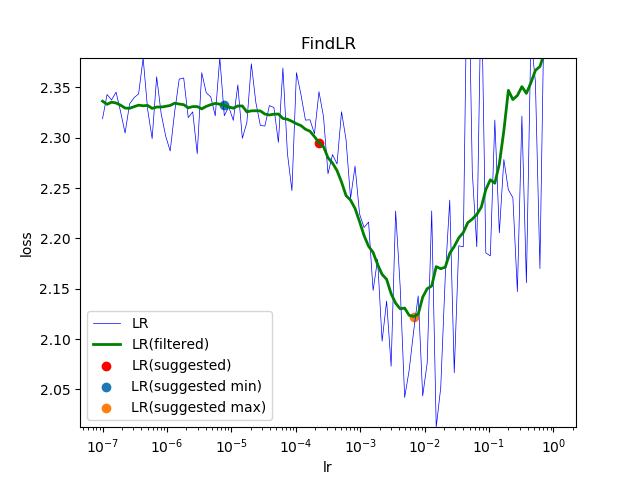

lr= 0.00022908676527677726, lr_min=7.76247116628692e-06, lr_max=0.0067608297539198114


In [60]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	0.60343788	0.76490143	0.74024682	141.185452
21	0.68676889	1.03368119	0.65863854	145.537268
22	0.72552874	0.96974432	0.67884156	144.373868
23	0.69921792	0.93095182	0.69775080	145.614125
24	0.67262384	0.79556719	0.72900080	146.836128
25	0.63637224	0.66358651	0.77229299	146.653877
26	0.59613330	0.65301336	0.77627389	146.116802
27	0.55912482	0.60386809	0.79130175	140.694762
28	0.52547877	0.58164622	0.79976115	141.061004
29	0.51032539	0.57495706	0.80115446	141.312313


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
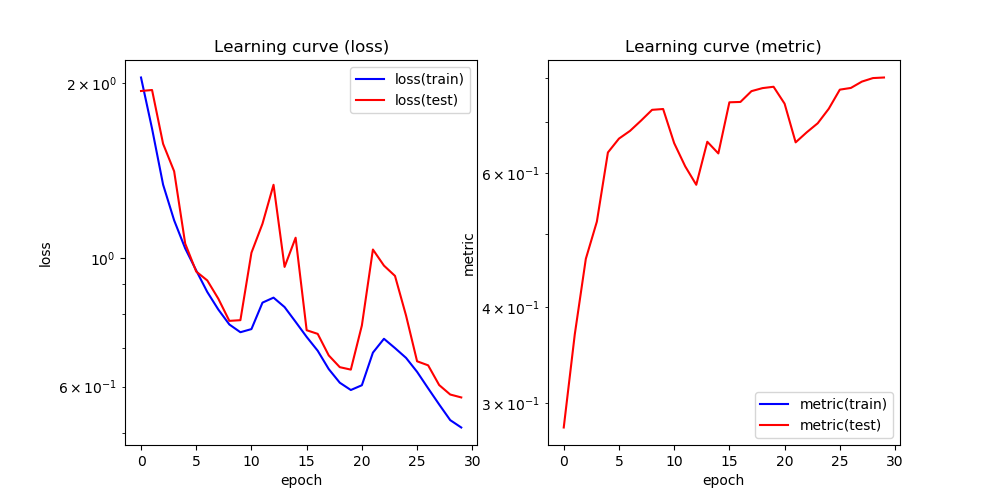

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
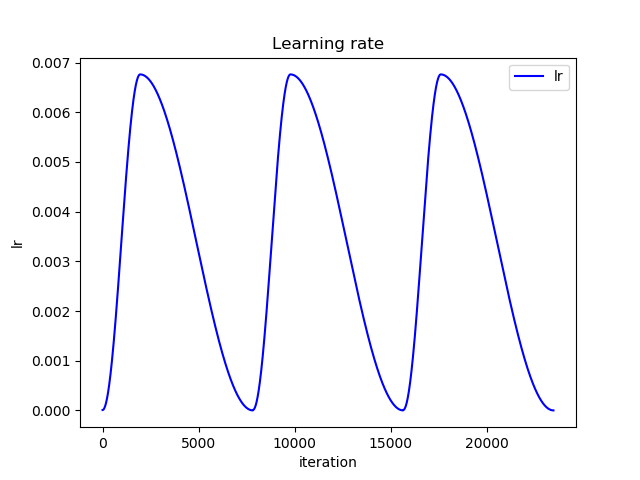

In [63]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)